In [1]:
import torch                           # 导入相关库
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

import os

# 构建神经网络
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = LeNet() 
summary(model, (1, 28, 28), device="cpu")

# 真正训练时size=(1, 1, 28, 28)
# 1个样本，1个通道（黑白图），长28，宽28

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,610
Trainable params: 61,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [2]:
def data_loader(mini_batch_size):
    data_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    # 准备训练数据
    train_set = datasets.MNIST('../data', train=True, transform=data_tf, download=False)
    # 准备测试数据
    test_set = datasets.MNIST('../data', train=False, transform=data_tf, download=False)
    # 装载训练集
    train_data = DataLoader(train_set, mini_batch_size, shuffle=True)
    # 装载测试集
    test_data = DataLoader(test_set, mini_batch_size, shuffle=False)
    return train_data, test_data

def train(epochs, mini_batch_size, eta):
    train_data, test_data, = data_loader(mini_batch_size)
    print(torch.cuda.is_available())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = LeNet().to(device)
    # 设置损失函数
    criterion = nn.CrossEntropyLoss()
    # 设置网络优化方式
    optimizer = torch.optim.Adam(net.parameters(), eta)
    losses = []
    test_acces = []
    for e in range(epochs):
        train_loss = 0
        for step, (data, label) in enumerate(train_data):
            net.train()
            data = Variable(data).cuda()
            label = Variable(label).cuda()
            out = net(data)
            loss = criterion(out, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        losses.append(train_loss / (step + 1))
        accuracy_test = test_net(net, test_data)
        test_acces.append(accuracy_test)
        print("epoch %d | loss = %.4f, test accuracy is %.3f %%." %(e, train_loss / (step + 1), accuracy_test))
        ckpt_dir = '../model'
        save_path = os.path.join(ckpt_dir, 'CNN_model_weight2.pth.tar') 
        torch.save({'state_dict': net.state_dict()}, save_path)
    return losses, test_acces
def test_net(net, test_data):
    test_acc = 0
    total_1 = 0
    for step, (im, labels) in enumerate(test_data):
        im = Variable(im).cuda()
        labels = Variable(labels).cuda()
        net.eval() # 将模型改为预测模式
        out = net(im)
        pred = out.argmax(1)
        total_1 += labels.size(0)
        test_acc += (pred == labels).sum()
    return 100. * test_acc.cpu().numpy() / total_1

True
epoch 0 | loss = 0.2679, test accuracy is 97.600 %.
epoch 1 | loss = 0.0723, test accuracy is 98.090 %.


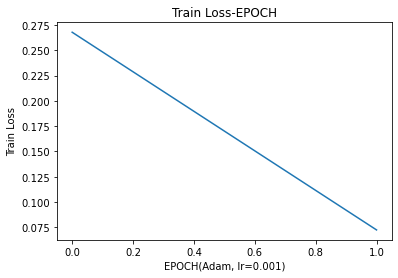

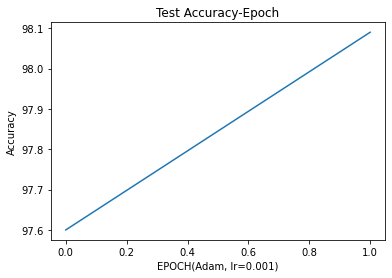

In [3]:
if __name__ == '__main__':
    epochs = 2
    mini_batch_size = 64
    eta = 0.001
    train__loss, test__accuracy = train(epochs, mini_batch_size, eta)
    plt.figure()
    x = range(0, epochs)
    plt.plot(x, train__loss)
    plt.title('Train Loss-EPOCH')
    plt.xlabel('EPOCH(Adam, lr=0.001)')
    plt.ylabel('Train Loss')
    plt.show()
    plt.figure()
    plt.plot(x, test__accuracy)
    plt.title('Test Accuracy-Epoch')
    plt.xlabel('EPOCH(Adam, lr=0.001)')
    plt.ylabel('Accuracy')
    plt.show()